<a href="https://colab.research.google.com/github/emimorgan97/Machine-Learning-Final-Project/blob/main/Vector_Quantization_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

from sklearn.decomposition import NMF
import gzip
import h5py
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

Mounted at /content/drive


In [ ]:
def display_images(images_data, num_images):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    for i in range(num_images):
        normalized_image = images_data[i] / 255.0 if images_data[i].max() > 1 else images_data[i]
        axes[i].imshow(images_data[i])
        axes[i].axis('off')
        axes[i].set_title(f"Image {i+1}")
    plt.show()

In [ ]:
# Paths to gzip-compressed HDF5 files
images_file_path = '/content/drive/MyDrive/ML_Data/pcamv1/camelyonpatch_level_2_split_train_x.h5.gz'
labels_file_path = '/content/drive/MyDrive/ML_Data/pcamv1/camelyonpatch_level_2_split_train_y.h5.gz'

# Number of images to read in each batch
chunk_size = 50

# Initialize lists to store data
images_data = []
labels_data = []

# Open gzip-compressed HDF5 files and read data in chunks
with gzip.open(images_file_path, 'rb') as f_images, h5py.File(f_images, 'r') as hf_images:
    with gzip.open(labels_file_path, 'rb') as f_labels, h5py.File(f_labels, 'r') as hf_labels:
        num_images = 10000  # set this depending on how many images you want

        for i in range(0, num_images, chunk_size):
            # Read chunk of image data
            images_chunk = hf_images['x'][i:i+chunk_size]
            images_data.extend(images_chunk)

            # Read corresponding chunk of labels data
            labels_chunk = hf_labels['y'][i:i+chunk_size]
            labels_data.extend(labels_chunk)

# Now you have images_data and labels_data containing the data of images and labels, respectively, in chunks.
# You can further process this data as needed.


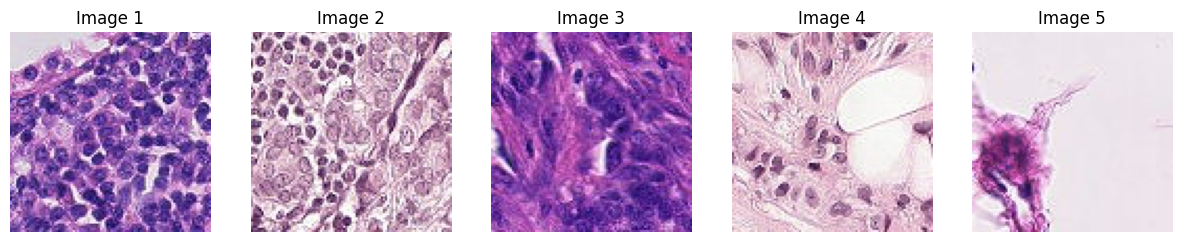

In [ ]:
display_images(images_data[:5], 5)

In [ ]:
def resize_to_center(image_data, target_size=(32, 32)):
    # Get original image size
    original_size = image_data.shape[:2]
    # Calculate top-left position for the new image
    top = (original_size[0] - target_size[0]) // 2
    left = (original_size[1] - target_size[1]) // 2
    # Crop the original image to the center
    cropped_image = image_data[top:top+target_size[0], left:left+target_size[1], :]
    return cropped_image

# Number of images to process
num_images = len(images_data)  # Assuming images_data contains all the image data

# Resize each image to center 32x32 pixels
resized_images = []
for image_data in images_data:
    resized_image_data = resize_to_center(image_data)
    resized_images.append(resized_image_data)

# Now you have resized_images containing the resized image data.
# You can further process this data as needed.


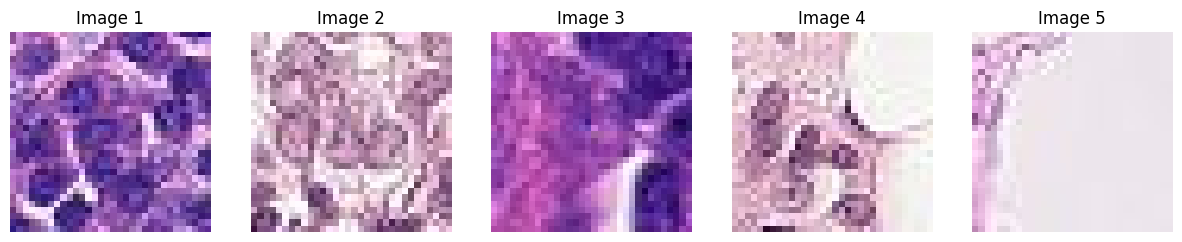

In [ ]:
# Visualize 5 resized images
display_images(resized_images[:5], 5)

In [ ]:
resized_images_array = np.array(resized_images)

# Normalize pixel values to [0, 1] range
normalized_images = resized_images_array / 255.0

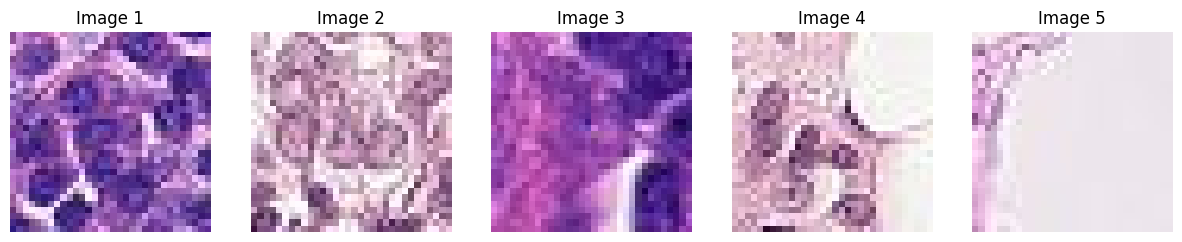

In [ ]:
display_images(normalized_images, 5)

In [ ]:
from sklearn.cluster import MiniBatchKMeans
import numpy as np

# Assuming labels_data is a list/array containing labels (0s and 1s)
# and resized_images is a list/array containing corresponding images

# Convert data to numpy arrays for easier manipulation
labels_data = np.array(labels_data)
resized_images = np.array(normalized_images)

# Define the number of clusters for VQ
num_clusters = 100 # Adjust this based on your requirement

# Initialize the MiniBatchKMeans model
vq_model = MiniBatchKMeans(n_clusters=num_clusters, random_state=42)

# Fit the model with all the data
#flattened_images = resized_images.reshape(len(resized_images), -1)
#vq_model.partial_fit(flattened_images)

# Initialize lists to store reconstructed images and corresponding labels
reconstructed_images = []
reconstructed_labels = []

# Iterate over unique labels
for label in np.unique(labels_data):
    # Get indices of images with the current label
    label_indices = np.where(labels_data == label)[0]

    # Batch size for processing images
    batch_size = 200  # You can adjust this based on your memory constraints

    # Iterate over batches of images with the current label
    for i in range(0, len(label_indices), batch_size):
        batch_indices = label_indices[i:i + batch_size]
        batch_images = resized_images[batch_indices]

        #train model on each specific batch (with matching classes)
        flattened_images = batch_images.reshape(len(batch_images), -1)
        vq_model.partial_fit(flattened_images)

        # Initialize list to store reconstructed batch images
        reconstructed_batch = []

        # Iterate over images in the batch
        for image in batch_images:
            # Flatten the image
            flattened_image = image.flatten()

            # Use the VQ model to find the nearest cluster centers
            nearest_cluster_index = vq_model.predict([flattened_image])[0]

            # Get the representative vector for the nearest cluster
            representative_vector = vq_model.cluster_centers_[nearest_cluster_index]

            # Reshape the representative vector to match the original image shape
            reconstructed_image = representative_vector.reshape(image.shape)

            # Append reconstructed image to the batch
            reconstructed_batch.append(reconstructed_image)

        # Append reconstructed batch and corresponding labels
        reconstructed_images.extend(reconstructed_batch)
        reconstructed_labels.extend([label] * len(reconstructed_batch))

        # Update the VQ model with the current batch
        batch_flattened_images = np.array([img.flatten() for img in batch_images])
        vq_model.partial_fit(batch_flattened_images)

# Convert reconstructed images and labels to numpy arrays
reconstructed_images = np.array(reconstructed_images)
reconstructed_labels = np.array(reconstructed_labels)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
shuffled_indices = np.random.permutation(len(reconstructed_images))
reconstructed_images = reconstructed_images[shuffled_indices]
reconstructed_labels = reconstructed_labels[shuffled_indices]

In [ ]:
def min_max_normalize(image_data):
    min_val = np.min(image_data)
    max_val = np.max(image_data)
    normalized_data = (image_data - min_val) / (max_val - min_val)
    return normalized_data

min_max_normalize(reconstructed_images)

array([[[[0.70379467, 0.50739518, 0.67820586],
         [0.69852999, 0.50136758, 0.67278752],
         [0.70383213, 0.50586554, 0.67780453],
         ...,
         [0.69838551, 0.50013531, 0.67150021],
         [0.70097925, 0.50187287, 0.67405191],
         [0.70073921, 0.50105187, 0.67395176]],

        [[0.70534648, 0.50835225, 0.67991438],
         [0.70045713, 0.50255475, 0.67456714],
         [0.70269082, 0.50440928, 0.67713489],
         ...,
         [0.69887092, 0.50064213, 0.67207277],
         [0.7005848 , 0.50126056, 0.67362076],
         [0.70128655, 0.5009135 , 0.67403509]],

        [[0.70053816, 0.50189734, 0.67453503],
         [0.69776631, 0.49910331, 0.6719948 ],
         [0.70106563, 0.50157704, 0.67511524],
         ...,
         [0.69941138, 0.5006857 , 0.67257501],
         [0.70048236, 0.50100447, 0.67340825],
         [0.70107786, 0.50054581, 0.6739296 ]],

        ...,

        [[0.69730535, 0.50170088, 0.67233803],
         [0.69855062, 0.50244467, 0.67334786]

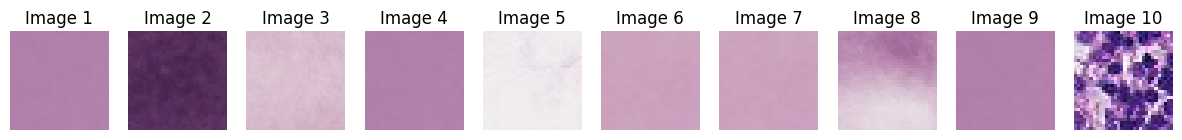

In [ ]:
display_images(reconstructed_images[:10], 10)

In [ ]:
# Function to pad images to be of size 96x96
def pad_images(images_data, target_size=(96, 96)):
    padded_images = []
    for image_data in images_data:
        # Calculate padding amounts for each dimension
        pad_height = max(target_size[0] - image_data.shape[0], 0)
        pad_width = max(target_size[1] - image_data.shape[1], 0)

        # Pad the image with zeros
        padded_image = np.pad(image_data, ((0, pad_height), (0, pad_width), (0, 0)), mode='constant')
        padded_images.append(padded_image)
    return padded_images

# Pad resized images to be of size 96x96
padded_images = pad_images(reconstructed_images)

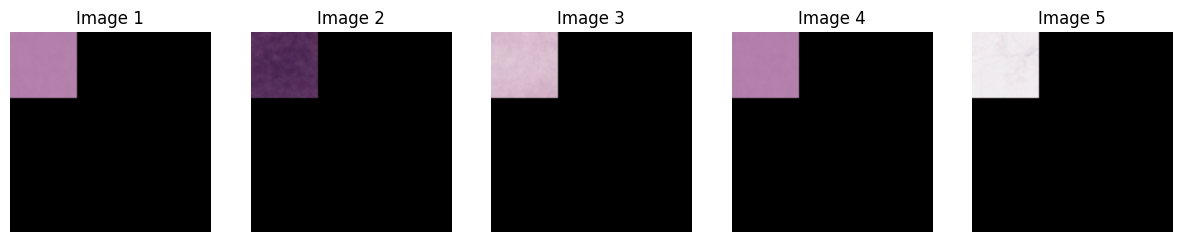

In [ ]:
display_images(padded_images[:5],5)

In [ ]:
import h5py
import gzip

# Paths for the output HDF5 and gzip files for images and labels
output_images_h5_file_path = 'VQ_images.h5'
output_labels_h5_file_path = 'VQ_labels.h5'
output_images_h5_gz_file_path = 'VQ_image.h5.gz'
output_labels_h5_gz_file_path = 'VQ_labels.h5.gz'

# Create HDF5 file to store padded images
with h5py.File(output_images_h5_file_path, 'w') as output_images_file:
    # Create a dataset to store padded images
    output_images_dataset = output_images_file.create_dataset('images', data=padded_images)

# Create HDF5 file to store labels
with h5py.File(output_labels_h5_file_path, 'w') as output_labels_file:
    # Create a dataset to store labels
    output_labels_dataset = output_labels_file.create_dataset('labels', data=labels_data)

# Gzip the HDF5 file for images
with open(output_images_h5_file_path, 'rb') as f_in:
    with gzip.open(output_images_h5_gz_file_path, 'wb') as f_out:
        f_out.writelines(f_in)

# Gzip the HDF5 file for labels
with open(output_labels_h5_file_path, 'rb') as f_in:
    with gzip.open(output_labels_h5_gz_file_path, 'wb') as f_out:
        f_out.writelines(f_in)

print("Padded images and labels saved to HDF5 files and gzip compressed successfully.")

Padded images and labels saved to HDF5 files and gzip compressed successfully.


In [ ]:
import shutil
destination_drive_path = '/content/drive/MyDrive/Training Data: Subset 10000 Images'
shutil.copy(output_images_h5_gz_file_path, destination_drive_path)
shutil.copy(output_labels_h5_gz_file_path, destination_drive_path)

'/content/drive/MyDrive/Training Data: Subset 10000 Images/VQ_labels.h5.gz'